In [1]:
#import necessary libraries
import pandas as pd
import pytz
from glob import glob
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import inspect
import time
import numpy as np
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
#input the data
files = glob('tmp*.csv')
files

['tmp37y3hzwj.csv',
 'tmpb6n1t_qb.csv',
 'tmp9uci4wac.csv',
 'tmp_424i9_2.csv',
 'tmpunyiwxpl.csv',
 'tmpzj47dpf4.csv']

In [3]:
#exploring the data
frames = [pd.read_csv(file) for file in files]
df = pd.concat(frames)
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,50;DHT22;3573;-1.289;36.825;2023-01-01T00:00:0...
1,50;DHT22;3573;-1.289;36.825;2023-01-01T00:00:0...
2,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...
3,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...
4,71;pms5003;35;-1.297;36.743;2023-01-01T00:00:1...


In [3]:
# Build your `wrangle` function
def wrangle(filepath):
    
    df=pd.read_csv(filepath)
    
    #split the data
    df[["sensor_id", "sensor_type",
    'location','lat','lon','timestamp','value_type',
    'value']] = df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)
    
    #drop columns
    df.drop(columns="sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value", inplace=True)
    
    #convert the type
    df["sensor_id"]=df["sensor_id"].astype(float)
    df['location']=df['location'].astype(float)
    df['lat']=df['lat'].astype(float)
    df['lon']=df['lon'].astype(float)
    df['value']=df['value'].astype(float)
    df['timestamp']= pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S')
    
    #set index as timestamp
    df = df.set_index('timestamp')
    
    #convert the time in Nairobi time
    df.index=df.index.tz_convert('Africa/Nairobi')
    
    #drop columns
    drop_cols=['sensor_id', 'sensor_type','location','lat', 'lon']
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [4]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
df.head()

,value_type,value
timestamp,,
2023-01-01 03:00:00.587438+03:00,humidity,99.9
2023-01-01 03:00:00.587438+03:00,temperature,17.1
2023-01-01 03:00:19.768006+03:00,P2,25.0
2023-01-01 03:00:19.768006+03:00,P1,35.4
2023-01-01 03:00:19.768006+03:00,P0,14.6


In [5]:
df = df[df["value_type"].str.contains("temperature") == False]
df = df[df["value_type"].str.contains("humidity") == False]
df = df[df["value_type"].str.contains("P0") == False]
df = df[df["value_type"].str.contains("P1") == False]
# Remove outliers
df = df[df["value"] < 500]
df= df['value'].resample('1H').mean().fillna(method='ffill').to_frame()

In [6]:
df['P2']=df['value']
df.drop(columns=['value'], inplace=True)

In [7]:
#data head overview
df.head()

,P2
timestamp,
2023-01-01 03:00:00+03:00,23.587349
2023-01-01 04:00:00+03:00,22.523567
2023-01-01 05:00:00+03:00,35.353654
2023-01-01 06:00:00+03:00,37.461234
2023-01-01 07:00:00+03:00,41.497801


In [8]:
df.shape

(4112, 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4112 entries, 2023-01-01 03:00:00+03:00 to 2023-06-21 10:00:00+03:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P2      4112 non-null   float64
dtypes: float64(1)
memory usage: 64.2 KB


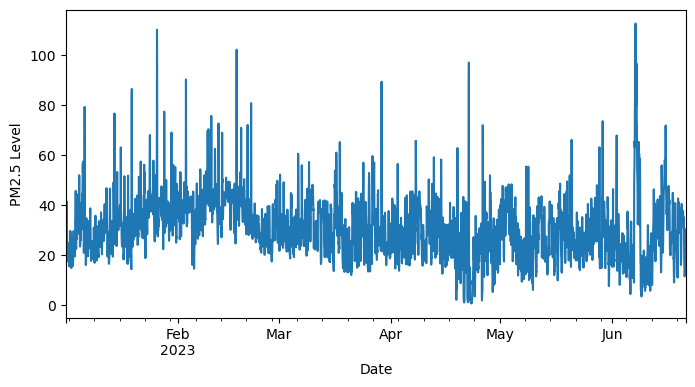

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

df['P2'].plot(xlabel='Date', ylabel='PM2.5 Level', ax=ax);

In [11]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationary
def adf_test(data):
    test_results_ADF = adfuller(data)
    print('ADF Statistic: ', test_results_ADF[0])
    print('P-Value: ', test_results_ADF[1])
    print('Critical Values:')
    for threshold, adf_stat in test_results_ADF[4].items():
        print('\t%s: %.2f' % (threshold, adf_stat))


print(adf_test(df['P2']))

ADF Statistic:  -7.008229291395888
P-Value:  7.031031343483054e-10
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
None


In [12]:
adfuller(df['P2'])

(-7.008229291395888,
 7.031031343483054e-10,
 27,
 4084,
 {'1%': -3.4319522073821083,
  '5%': -2.8622479674655517,
  '10%': -2.5671468579348855},
 26251.006880477486)

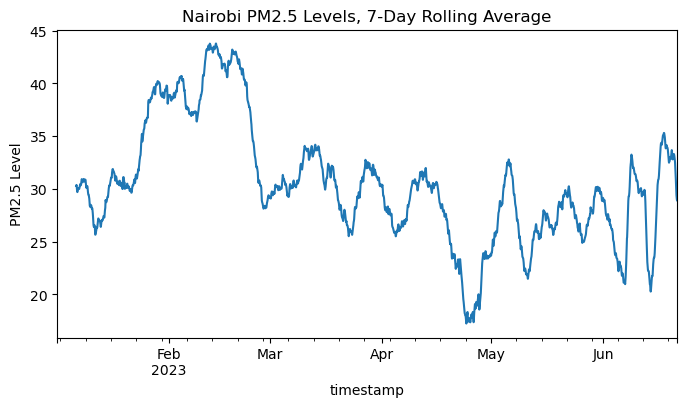

In [12]:
fig, ax = plt.subplots(figsize=(8,4))
df['P2'].rolling(128).mean().plot(ax=ax, ylabel='PM2.5 Level', 
                           title="Nairobi PM2.5 Levels, 7-Day Rolling Average");

In [13]:
df.to_csv('file2.csv')

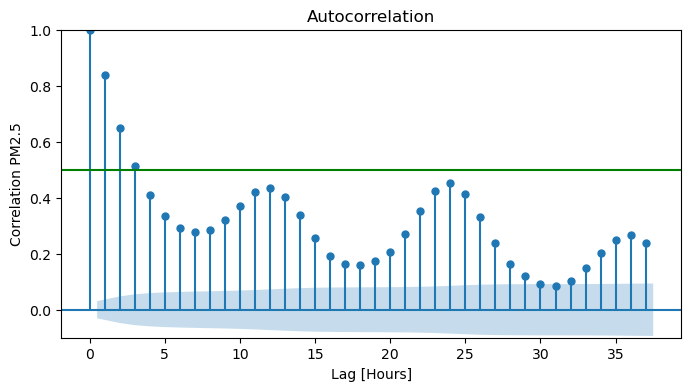

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(df, ax=ax)
ax.set_ylim(-0.1,1)
plt.axhline(y=0.5, color='green')
plt.axhline(y=-0.5, color='green')
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation PM2.5");

In [24]:
cutoff_test = int(len(df['P2'])*0.80)
y_train = df['P2'].iloc[:cutoff_test].dropna()
y_test = df['P2'].iloc[cutoff_test:].dropna()
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3289,)
y_test shape: (823,)


In [25]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)


print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 30.893072528565096
Baseline MAE: 8.668635947190532


In [61]:
lag = range(1, 38)
mean_abs = []
for p in lag:
    # Train model and fit
    model = AutoReg(y_train,lags=p).fit()
    # Generate training predictions
    y_pred = model.predict().dropna()
    # Calculate training mean absolute errors
    mae = mean_absolute_error(y_train.iloc[p:],y_pred)
    # Append mae to mean_abs list
    mean_abs.append(mae)
mae_series = pd.Series(mean_abs, name="mae", index=lag)
mae_series.head()

1    4.320304
2    4.218506
3    4.224218
4    4.224346
5    4.226135
Name: mae, dtype: float64

In [62]:
mean_abs.index(min(mean_abs))

35

In [26]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=3).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])

In [20]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 4.32


In [30]:
test_mae = mean_squared_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 39.85


In [28]:
df_pred_test=pd.DataFrame(
   {'True Values': y_test, 'Predictions':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM2.5 Levels"})
fig.show()

In [33]:
mape=np.mean(np.abs(y_pred_wfv-y_test)/np.abs(y_test))
mape

0.1912777938469557

In [69]:
lag=range(1, 37)
q_params=range(0,3)
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in lag:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (1, 0, 0) in 6.97 seconds.
Trained ARIMA (1, 0, 1) in 2.02 seconds.
Trained ARIMA (1, 0, 2) in 1.44 seconds.
Trained ARIMA (2, 0, 0) in 1.58 seconds.
Trained ARIMA (2, 0, 1) in 1.53 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (2, 0, 2) in 9.74 seconds.
Trained ARIMA (3, 0, 0) in 1.1 seconds.
Trained ARIMA (3, 0, 1) in 3.07 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (3, 0, 2) in 3.7 seconds.
Trained ARIMA (4, 0, 0) in 1.55 seconds.
Trained ARIMA (4, 0, 1) in 4.07 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (4, 0, 2) in 4.85 seconds.
Trained ARIMA (5, 0, 0) in 1.49 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (5, 0, 1) in 11.92 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (5, 0, 2) in 13.71 seconds.
Trained ARIMA (6, 0, 0) in 1.75 seconds.
Trained ARIMA (6, 0, 1) in 10.99 seconds.
Trained ARIMA (6, 0, 2) in 8.63 seconds.
Trained ARIMA (7, 0, 0) in 2.56 seconds.
Trained ARIMA (7, 0, 1) in 13.4 seconds.
Trained ARIMA (7, 0, 2) in 15.81 seconds.
Trained ARIMA (8, 0, 0) in 5.98 seconds.
Trained ARIMA (8, 0, 1) in 14.1 seconds.
Trained ARIMA (8, 0, 2) in 14.43 seconds.
Trained ARIMA (9, 0, 0) in 5.16 seconds.
Trained ARIMA (9, 0, 1) in 13.42 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (9, 0, 2) in 23.92 seconds.
Trained ARIMA (10, 0, 0) in 6.01 seconds.
Trained ARIMA (10, 0, 1) in 15.42 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (10, 0, 2) in 26.42 seconds.
Trained ARIMA (11, 0, 0) in 6.88 seconds.
Trained ARIMA (11, 0, 1) in 16.06 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (11, 0, 2) in 32.48 seconds.
Trained ARIMA (12, 0, 0) in 5.5 seconds.
Trained ARIMA (12, 0, 1) in 15.03 seconds.
Trained ARIMA (12, 0, 2) in 21.63 seconds.
Trained ARIMA (13, 0, 0) in 7.15 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (13, 0, 1) in 36.01 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (13, 0, 2) in 40.93 seconds.
Trained ARIMA (14, 0, 0) in 9.31 seconds.
Trained ARIMA (14, 0, 1) in 33.69 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (14, 0, 2) in 47.27 seconds.
Trained ARIMA (15, 0, 0) in 13.25 seconds.
Trained ARIMA (15, 0, 1) in 30.01 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (15, 0, 2) in 54.05 seconds.
Trained ARIMA (16, 0, 0) in 12.66 seconds.
Trained ARIMA (16, 0, 1) in 15.33 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (16, 0, 2) in 46.94 seconds.
Trained ARIMA (17, 0, 0) in 13.59 seconds.
Trained ARIMA (17, 0, 1) in 57.82 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (17, 0, 2) in 64.38 seconds.
Trained ARIMA (18, 0, 0) in 14.6 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (18, 0, 1) in 63.81 seconds.
Trained ARIMA (18, 0, 2) in 55.16 seconds.
Trained ARIMA (19, 0, 0) in 20.32 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (19, 0, 1) in 80.11 seconds.
Trained ARIMA (19, 0, 2) in 86.25 seconds.
Trained ARIMA (20, 0, 0) in 24.89 seconds.
Trained ARIMA (20, 0, 1) in 86.78 seconds.
Trained ARIMA (20, 0, 2) in 80.48 seconds.
Trained ARIMA (21, 0, 0) in 29.8 seconds.
Trained ARIMA (21, 0, 1) in 110.79 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (21, 0, 2) in 118.69 seconds.
Trained ARIMA (22, 0, 0) in 32.33 seconds.
Trained ARIMA (22, 0, 1) in 79.38 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (22, 0, 2) in 132.63 seconds.
Trained ARIMA (23, 0, 0) in 43.22 seconds.
Trained ARIMA (23, 0, 1) in 93.03 seconds.
Trained ARIMA (23, 0, 2) in 134.77 seconds.
Trained ARIMA (24, 0, 0) in 39.22 seconds.
Trained ARIMA (24, 0, 1) in 103.05 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 0, 2) in 164.85 seconds.
Trained ARIMA (25, 0, 0) in 50.13 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (25, 0, 1) in 174.37 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (25, 0, 2) in 157.27 seconds.
Trained ARIMA (26, 0, 0) in 44.35 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (26, 0, 1) in 155.54 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (26, 0, 2) in 162.01 seconds.
Trained ARIMA (27, 0, 0) in 57.95 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (27, 0, 1) in 182.79 seconds.
Trained ARIMA (27, 0, 2) in 171.96 seconds.
Trained ARIMA (28, 0, 0) in 56.39 seconds.
Trained ARIMA (28, 0, 1) in 101.12 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (28, 0, 2) in 257.04 seconds.
Trained ARIMA (29, 0, 0) in 66.45 seconds.
Trained ARIMA (29, 0, 1) in 131.32 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (29, 0, 2) in 244.41 seconds.
Trained ARIMA (30, 0, 0) in 77.52 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (30, 0, 1) in 229.42 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (30, 0, 2) in 250.96 seconds.
Trained ARIMA (31, 0, 0) in 93.14 seconds.
Trained ARIMA (31, 0, 1) in 227.67 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (31, 0, 2) in 290.86 seconds.
Trained ARIMA (32, 0, 0) in 91.12 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (32, 0, 1) in 291.92 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (32, 0, 2) in 309.93 seconds.
Trained ARIMA (33, 0, 0) in 121.57 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (33, 0, 1) in 339.46 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (33, 0, 2) in 345.41 seconds.
Trained ARIMA (34, 0, 0) in 272.39 seconds.
Trained ARIMA (34, 0, 1) in 391.86 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (34, 0, 2) in 915.69 seconds.
Trained ARIMA (35, 0, 0) in 250.91 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (35, 0, 1) in 747.97 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (35, 0, 2) in 756.29 seconds.
Trained ARIMA (36, 0, 0) in 124.8 seconds.
Trained ARIMA (36, 0, 1) in 205.8 seconds.


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (36, 0, 2) in 429.09 seconds.

{1: [4.3211475939159305, 4.221144012491491, 4.227655641936504], 2: [4.218762489741224, 4.227998081962561, 4.226880184566585], 3: [4.227596790995838, 4.2267746462227285, 4.226818193904951], 4: [4.2266097331167405, 4.226299774426418, 4.226702260170781], 5: [4.228763336190702, 4.1282589252528785, 4.105270611273189], 6: [4.224106318799712, 4.120422909590457, 4.13193678308968], 7: [4.201863768705861, 4.104772119587225, 4.123260701955526], 8: [4.1675715354981095, 4.098837251869762, 4.105306953944632], 9: [4.1123717987216315, 4.068478790061445, 4.098707590657558], 10: [4.053738733560983, 4.049240380518282, 3.997922116029605], 11: [4.046127328417516, 4.048444192003006, 4.044043731218002], 12: [4.049915840521747, 4.048246520268321, 4.0471827828101485], 13: [4.043043990306209, 4.0369843765554965, 4.048073071868484], 14: [4.036882642832651, 4.033966060761594, 4.0363427715499895], 15: [4.038869060113187, 4.0387234304331585, 4.039814034682856], 16: [4.03

In [70]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,4.3211,4.2188,4.2276,4.2266,4.2288,4.2241,4.2019,4.1676,4.1124,4.0537,...,3.9219,3.9222,3.9216,3.9207,3.9230,3.9216,3.9220,3.9185,3.9185,3.9157
1,4.2211,4.2280,4.2268,4.2263,4.1283,4.1204,4.1048,4.0988,4.0685,4.0492,...,3.9222,3.9218,3.9210,3.9206,3.9226,3.9183,3.9194,3.9193,3.9173,3.9172
2,4.2277,4.2269,4.2268,4.2267,4.1053,4.1319,4.1233,4.1053,4.0987,3.9979,...,3.9229,3.9213,3.9201,3.9221,3.9241,3.9230,3.9185,3.9178,3.9163,3.9145


In [14]:
m={1: [4.3211475939159305, 4.221144012491491, 4.227655641936504], 2: [4.218762489741224, 4.227998081962561, 4.226880184566585], 3: [4.227596790995838, 4.2267746462227285, 4.226818193904951], 4: [4.2266097331167405, 4.226299774426418, 4.226702260170781], 5: [4.228763336190702, 4.1282589252528785, 4.105270611273189], 6: [4.224106318799712, 4.120422909590457, 4.13193678308968], 7: [4.201863768705861, 4.104772119587225, 4.123260701955526], 8: [4.1675715354981095, 4.098837251869762, 4.105306953944632], 9: [4.1123717987216315, 4.068478790061445, 4.098707590657558], 10: [4.053738733560983, 4.049240380518282, 3.997922116029605], 11: [4.046127328417516, 4.048444192003006, 4.044043731218002], 12: [4.049915840521747, 4.048246520268321, 4.0471827828101485], 13: [4.043043990306209, 4.0369843765554965, 4.048073071868484], 14: [4.036882642832651, 4.033966060761594, 4.0363427715499895], 15: [4.038869060113187, 4.0387234304331585, 4.039814034682856], 16: [4.038896923348867, 4.038897494132759, 4.041060800179268], 17: [4.0419268440918295, 4.0145978451317115, 4.050247591777878], 18: [4.041499347881884, 4.0091747914119145, 4.016224491869459], 19: [4.0407786318765515, 3.9980337672721755, 4.011829927480251], 20: [4.029914045057358, 3.9903725946242137, 4.004801328065713], 21: [3.999799981054551, 3.9711771778347718, 3.945863346401429], 22: [3.9654904257230656, 3.9531723497112026, 3.9216332584565], 23: [3.938720116452042, 3.9409329409742773, 3.9247488861204345], 24: [3.944457071864749, 3.9419688352388693, 3.926030820407181], 25: [3.9280396596485545, 3.9232161115586885, 3.9293341571021725], 26: [3.923470207922412, 3.9227545496215206, 3.9227885586352857], 27: [3.9219016416902286, 3.9221567805116133, 3.9228909867528374], 28: [3.922191479384893, 3.9218115744652335, 3.921287508996705], 29: [3.92158320014741, 3.9210058424626495, 3.9201006568669854], 30: [3.920683101862689, 3.9206421204385156, 3.922070873337302], 31: [3.923022385614667, 3.9225663441684855, 3.9241261281746076], 32: [3.9215585665666888, 3.9183201261933074, 3.9229564895875466], 33: [3.922005464994767, 3.9194111510742244, 3.9185344521497316], 34: [3.91845821374486, 3.9193153630677315, 3.9178253335955335], 35: [3.918460712415909, 
3.9172713279843308, 3.916252549576179], 
   36: [3.9157156637945447, 3.917189334749002, 3.914513885898658]}

In [15]:
mae_df = pd.DataFrame(m)
mae_df.round(4)

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
0,4.3211,4.2188,4.2276,4.2266,4.2288,4.2241,4.2019,4.1676,4.1124,4.0537,...,3.9219,3.9222,3.9216,3.9207,3.9230,3.9216,3.9220,3.9185,3.9185,3.9157
1,4.2211,4.2280,4.2268,4.2263,4.1283,4.1204,4.1048,4.0988,4.0685,4.0492,...,3.9222,3.9218,3.9210,3.9206,3.9226,3.9183,3.9194,3.9193,3.9173,3.9172
2,4.2277,4.2269,4.2268,4.2267,4.1053,4.1319,4.1233,4.1053,4.0987,3.9979,...,3.9229,3.9213,3.9201,3.9221,3.9241,3.9230,3.9185,3.9178,3.9163,3.9145


In [16]:
mae_df.min(axis=1)

0    3.915716
1    3.917189
2    3.914514
dtype: float64

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model =ARIMA(history,order=[36,0,2]).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceW

In [ ]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))
test_mae = r2_score(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

In [ ]:
df_pred_test=pd.DataFrame(
   {'y_test': y_test, 'y_pred':y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.update_layout(
    title="Dar es Salaam Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)

fig.show()